# AR1 processes: approximation check

Tony Wong (<anthony.e.wong@colorado.edu>)

---

Some preliminaries:

In [1]:
library(mvtnorm)
library(repr)
set.seed(1234)

Given:
* Modeled time series: $\eta_t$, $1 \leq t \leq N$
* Data time series: $y_t$
* Model-data residuals: $r_t = y_t - \eta_t$

We suppose the model-date residuals $r_t$ are governed by a mean-0 first-order autoregressive process (AR1). Mean-0 implies there is no overall long-term drift. Such an AR1 model is:  $r_{t} = \rho r_{t-1} + \epsilon_t$, where $\epsilon_t \sim N(0, \sigma^2)$, $\sigma^2$ is the innovation variance and $\rho$ is the lag-1 autocorrelation coefficient. The AR1 process variance, $\sigma_{proc}^2 = \textrm{Var}(r_t)$, is given by:

$\begin{align*}
  \textrm{Var}(r_t) &= \textrm{Var}(\rho r_{t-1} + \epsilon_t) \\
    \sigma_{proc}^2 &= \textrm{Var}(\rho r_{t-1}) + \textrm{Var}(\epsilon_t) \\
                    &= \rho^2 \textrm{Var}(r_{t-1}) + \sigma^2 \\
                    &= \rho^2 \sigma_{proc}^2 + \sigma^2 \\
  \sigma_{proc}^2 (1-\rho^2) &= \sigma^2 \\
  \sigma_{proc}^2 &= \dfrac{\sigma^2}{1-\rho^2}
\end{align*}$

One can also check that $E[r_t] = 0$ (i.e., this is indeed a mean-0 AR process).

Suppose we have AR1 parameters: $\sigma = 1$ and $\rho = 0.9$.

In [2]:
rho <- 0.9
sigma <- 1
sigma_proc <- sigma/sqrt(1-rho*rho)

We want to answer the question: given a set of residuals, $r_t, 1 \leq t \leq N$, what is the likelihood of our data, given the model that produced these residuals?  Or, more informally, what is the likelihood function value?

To answer this question, let's first draw a set of residuals that follow an AR1 process.

### One way to draw random sample of residuals:

Initial residual considered distributed $r_1 \sim N(0, \sigma_{proc}^2)$, where $\sigma_{proc} = \dfrac{\sigma}{\sqrt{1-\rho^2}}$, then we can draw $r_t$ for $2 \leq t \leq N$ from $N(\rho r_{t-1}, \sigma^2)$.

The AR1 approximation method in BRICK is using $w_t = r_t - \rho r_{t-1} \sim N(0, \sigma^2)$

In [3]:
N <- 200
r1 <- rep(NA, N)
r1[1] <- rnorm(mean=0, sd=sigma_proc, n=1)
for (t in 2:N) {
    r1[t] <- rnorm(mean=rho*r1[t-1], sd=sigma, n=1)
}

### Let's talk covariances

Consider instead the residuals vector $\vec{r} = [r_1, r_2, \ldots, r_N]^T$. Let's build up the covariance matrix, $\Sigma_{AR1}$, of this guy.

Covariance matrix is defined to be:

$\Sigma_{AR1} = \left( \begin{array}{ccccc} E[(r_1-\bar{r_1})(r_1-\bar{r_1})]  & E[(r_1-\bar{r_1})(r_2-\bar{r_2})] & E[(r_1-\bar{r_1})(r_3-\bar{r_3})] & \cdots & E[(r_1-\bar{r_1})(r_N-\bar{r_N})] \\
  E[(r_2-\bar{r_2})(r_1-\bar{r_1})] & E[(r_2-\bar{r_2})(r_2-\bar{r_2})]   & E[(r_2-\bar{r_2})(r_3-\bar{r_3})]  & \cdots & E[(r_2-\bar{r_2})(r_N-\bar{r_N})] \\
  E[(r_3-\bar{r_3})(r_1-\bar{r_1})] & E[(r_3-\bar{r_3})(r_2-\bar{r_2})]   & E[(r_3-\bar{r_3})(r_3-\bar{r_3})]  & \cdots & E[(r_3-\bar{r_3})(r_N-\bar{r_N})] \\
                                           \vdots &      &        & \ddots & \\
  E[(r_N-\bar{r_N})(r_1-\bar{r_1})] & E[(r_N-\bar{r_N})(r_2-\bar{r_2})]   & E[(r_N-\bar{r_N})(r_3-\bar{r_3})]  & \cdots & E[(r_N-\bar{r_N})(r_N-\bar{r_N})] \\
                                           \end{array} \right)$

But we have a mean-0 process ($E[r_t]=0$), so all of those $\bar{r_t} =0$ and things simplify a bit to:

$\Sigma_{AR1} = \left( \begin{array}{ccccc} E[r_1^2]  & E[r_1 r_2] & E[r_1 r_3] & \cdots & E[r_1 r_N] \\
  E[r_2 r_1] & E[r_2^2]   & E[r_2 r_3]  & \cdots & E[r_2 r_N] \\
  E[r_3 r_1] & E[r_3 r_2]   & E[r_3^2]  & \cdots & E[r_3 r_N] \\
                                           \vdots &      &        & \ddots & \\
  E[r_N r_1] & E[r_N r_2]   & E[r_N r_3]  & \cdots & E[r_N^2] \\
                                           \end{array} \right)$

Along the diagonal, we have $E[r_t^2]$. We reconnect with our old friend, the variance formula: $\textrm{Var}(r_t) = E[r_t^2] - E[r_t]^2$.  But, it turns out $E[r_t]=0$, so we're left with $E[r_t^2] = \textrm{Var}(r_t) = \sigma_{proc}^2$ all down the diagonal.

As for the off-diagonal elements, let's just look at a couple, notice a pattern, and then take for granted that this pattern holds.

The row 1, column 2 element of $\Sigma_{AR1}$ is:

$\begin{align*}
  E[r_1 r_2] &= E[r_1 (\rho r_1 + \epsilon_2)] \\
             &= E[\rho r_1^2] + E[r_1 \epsilon_2] \\
             &= \rho E[r_1^2] \\
             &= \rho \sigma_{proc}^2
\end{align*}$

This used the fact that $E[r_1 \epsilon_2] = 0$ because both $E[r_1]=0$ and $E[\epsilon_2]=0$.

Similarly, the row 1, column 3 element of $\Sigma_{AR1}$ is:

$\begin{align*}
  E[r_1 r_3] &= E[r_1 (\rho r_2 + \epsilon_3)] \\
             &= E[r_1 (\rho (\rho r_1 + \epsilon_2) + \epsilon_3)] \\
             &= E[r_1 (\rho^2 r_1 + \rho \epsilon_2 + \epsilon_3)] \\
             &= E[\rho^2 r_1^2 + \rho r_1 \epsilon_2 + r_1 \epsilon_3] \\
             &= E[\rho^2 r_1^2] + \rho E[r_1 \epsilon_2] + E[r_1 \epsilon_3] \\
             &= \rho^2 E[r_1^2] \\
             &= \rho^2 \sigma_{proc}^2
\end{align*}$

Where, again, we used the fact that $E[r_{t_1} \epsilon_{t_2}] = 0$ for all $t_1, t_2$.

Continuing this pattern away from the diagonal, we find:

$\Sigma_{AR1} = \dfrac{\sigma^2}{1-\rho^2}
                   \left( \begin{array}{ccccc} 1      & \rho & \rho^2 & \cdots & \rho^{N-1} \\
                                               \rho   & 1    & \rho   & \cdots & \rho^{N-2} \\
                                               \rho^2 & \rho & 1      & \cdots & \rho^{N-3} \\
                                               \vdots &      &        & \ddots & \\
                                               \rho^{N-1} &  &        &        & 1
                                               \end{array} \right)$
                                               
And since $E[r_t] = 0$ for each $t$, $E[\vec{r}] = \vec{0}$. Thus, $\vec{r} \sim MVN(\vec{0}, \Sigma_{AR1})$, a multivariate normal distribution centered at $\vec{0}$ and with covariance $\Sigma_{AR1}$.

### Another way to draw random sample of residuals

This multivariate normal interpretation gives rise to another form for drawing a random sample of residuals. Here, we construct the $\Sigma_{AR1}$ matrix (`Sigma`) and draw a sample:

In [4]:
powers <- abs(outer(1:N, 1:N, "-"))
Sigma <- sigma_proc*sigma_proc * (rho^powers)
r2 <- rmvnorm(mean=rep(0,N), sigma=Sigma, n=1)

### Let's plot them and see how they compare

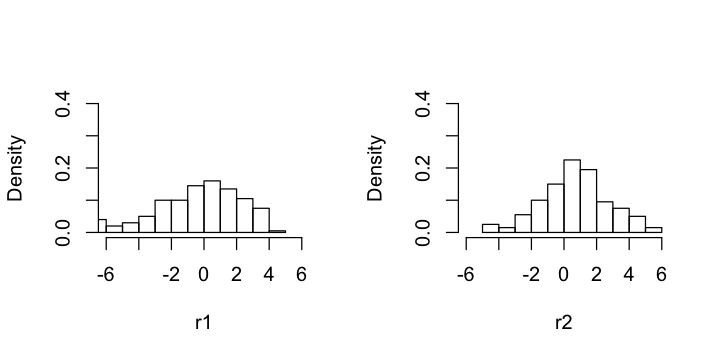

In [5]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
hist(r1, freq=FALSE, main='', xlim=c(-6,6), ylim=c(0,.4))
hist(r2, freq=FALSE, main='', xlim=c(-6,6), ylim=c(0,.4))

### We care about the *likelihood function*, dammit!

Not bad but we want to know how this affects the likelihood function.

`r1` was cooked up using exactly the definition of the AR1 process. Here is the likelihood function for `r1`, using the approximation:

In [6]:
# whitened residuals
w <- r1[2:N] - rho*r1[1:(N-1)]
ll1 <- sum(dnorm(w, mean=0, sd=sigma, log=TRUE))
print(ll1)

[1] -286.1289


Now, use the $\Sigma_{AR1}$ matrix and multivariate normal:

In [7]:
ll2 <- dmvnorm(r1, mean=rep(0,N), sigma=Sigma, log=TRUE)
print(ll2)

[1] -288.6068


Neat-o - that's pretty close! But let's see how well we do on average.

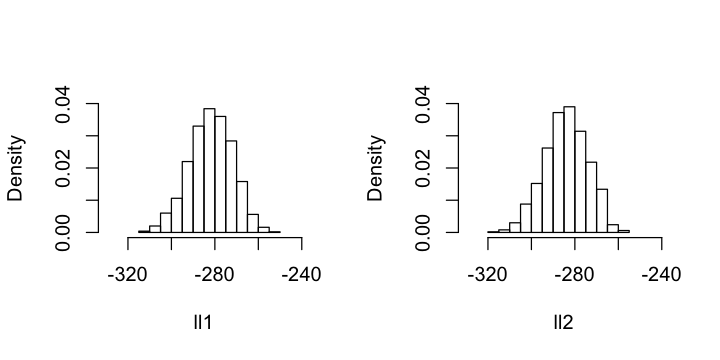

In [8]:
n_sample <- 1000
ll1 <- rep(NA, n_sample)
ll2 <- rep(NA, n_sample)
for (k in 1:n_sample) {
    # draw some random AR1 process
    r1 <- rep(NA, N)
    r1[1] <- rnorm(mean=0, sd=sigma_proc, n=1)
    for (t in 2:N) {
        r1[t] <- rnorm(mean=rho*r1[t-1], sd=sigma, n=1)
    }
    # get likelihood using the approximation method
    w <- r1[2:N] - rho*r1[1:(N-1)]
    ll1[k] <- sum(dnorm(w, mean=0, sd=sigma, log=TRUE))
    # get likelihood using the matrix method
    ll2[k] <- dmvnorm(r1, mean=rep(0,N), sigma=Sigma, log=TRUE)
}

# plot the two distributions side-by-side
# these xlim and ylim should work well. adjust if not.
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
hist(ll1, freq=FALSE, main='', xlim=c(-330, -240), ylim=c(0,.04))
hist(ll2, freq=FALSE, main='', xlim=c(-330, -240), ylim=c(0,.04))

**Nice.**